In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
import joblib

In [2]:
train = pd.read_csv('Dataset/Train/train.csv', delimiter=',',escapechar='\\',header=0,on_bad_lines='skip', encoding='utf-8')
test = pd.read_csv('Dataset/Test/test.csv', delimiter=',',escapechar='\\',header=0,on_bad_lines='skip', encoding='utf-8')

In [3]:
zero_cols = train.columns[(train == 0).all()]
print(list(zero_cols))

['onus_attribute_28']


In [4]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, SMOTENC

# Split X / y
X = train.drop(columns=['bad_flag', 'account_number', 'onus_attribute_28'])
y = train['bad_flag']

# Column lists
# num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# print(f"Total: {len(num_cols)}")
print(f"{len(X.columns)} columns")

1213 columns


## Smote

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE  # use SMOTENC if you have categoricals

# 1) Impute & keep width
imputer = SimpleImputer(strategy="median", keep_empty_features=True)
X_imp_np = imputer.fit_transform(X)

# 2) Back to DataFrame with names
X_imp = pd.DataFrame(X_imp_np, columns=X.columns, index=X.index)

# 3) Drop dead columns explicitly (all-constant after imputation)
dead_cols = [c for c in X_imp.columns if X_imp[c].nunique(dropna=True) <= 1]
if dead_cols:
    X_imp = X_imp.drop(columns=dead_cols)

# 4) Choose oversampling amount (example: +40% minority, cap at balance)
counts = Counter(y)
min_class = min(counts, key=counts.get)
n_min = counts[min_class]
n_maj = max(counts.values())
target_ratio = min(1.0, (n_min * 1.90) / n_maj)   # use 1.10 for +10%

# safe k_neighbors
k = max(1, min(5, n_min - 1))

smote = SMOTE(sampling_strategy=target_ratio, k_neighbors=k, random_state=42)
X_res_np, y_res = smote.fit_resample(X_imp.values, y.values)

# 5) Back to DataFrame/Series
X_sample = pd.DataFrame(X_res_np, columns=X_imp.columns)
y_sample = pd.Series(y_res, name=y.name)

print("Dropped dead columns:", dead_cols)
print("Original:", counts)
print("Resampled:", Counter(y_sample))
print("Shapes:", X_sample.shape, y_sample.shape)


Dropped dead columns: ['transaction_attribute_152', 'transaction_attribute_191', 'transaction_attribute_524', 'transaction_attribute_525', 'transaction_attribute_582', 'transaction_attribute_621', 'bureau_4', 'bureau_16', 'bureau_26', 'bureau_38', 'bureau_47', 'bureau_56', 'bureau_70', 'bureau_80', 'bureau_90', 'bureau_100', 'bureau_110', 'bureau_120', 'bureau_131', 'bureau_142', 'bureau_152', 'bureau_162', 'bureau_172', 'bureau_182', 'bureau_192', 'bureau_202', 'bureau_212', 'bureau_222', 'bureau_232', 'bureau_242', 'bureau_252', 'bureau_262', 'bureau_272', 'bureau_282', 'bureau_292', 'bureau_302', 'bureau_312', 'bureau_322', 'bureau_332', 'bureau_342', 'bureau_352', 'bureau_362', 'bureau_372', 'bureau_382', 'bureau_392', 'bureau_402', 'bureau_412', 'bureau_423', 'bureau_436', 'bureau_447', 'bureau_enquiry_7', 'bureau_enquiry_17', 'bureau_enquiry_27', 'bureau_enquiry_37', 'bureau_enquiry_47']
Original: Counter({0: 95434, 1: 1372})
Resampled: Counter({0: 95434, 1: 2606})
Shapes: (98040

In [6]:
X_sample.shape, y_sample.shape

((98040, 1158), (98040,))

In [7]:
y_sample.value_counts()

bad_flag
0    95434
1     2606
Name: count, dtype: int64

In [8]:
train['bad_flag'].value_counts()

bad_flag
0    95434
1     1372
Name: count, dtype: int64

## Train Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [10]:
model = lgb.LGBMClassifier(
    n_estimators=30,
    learning_rate=0.08,
    colsample_bytree=0.8,
    max_depth=3,
    device='gpu',
)

model.fit(X_train, y_train)

importance = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature' : X_sample.columns,
    'Importance' : importance
}).sort_values(by='Importance', ascending=False)

[LightGBM] [Info] Number of positive: 2085, number of negative: 76347
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 181696
[LightGBM] [Info] Number of data points in the train set: 78432, number of used features: 1124
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 169 dense feature groups (12.87 MB) transferred to GPU in 0.007424 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026584 -> initscore=-3.600520
[LightGBM] [Info] Start training from score -3.600520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

                        Feature  Importance
1091          onus_attribute_26          17
1093          onus_attribute_29          13
1129          bureau_enquiry_25          11
1067           onus_attribute_2          10
1099          onus_attribute_35           8
...                         ...         ...
395   transaction_attribute_397           0
396   transaction_attribute_398           0
397   transaction_attribute_399           0
398   transaction_attribute_400           0
1157          onus_attribute_48           0

[1158 rows x 2 columns]


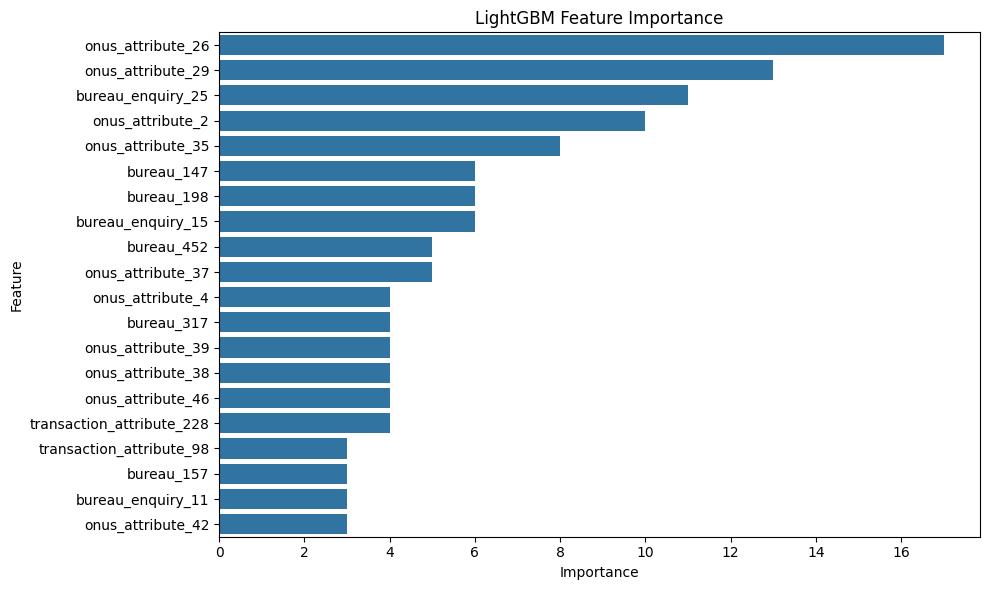

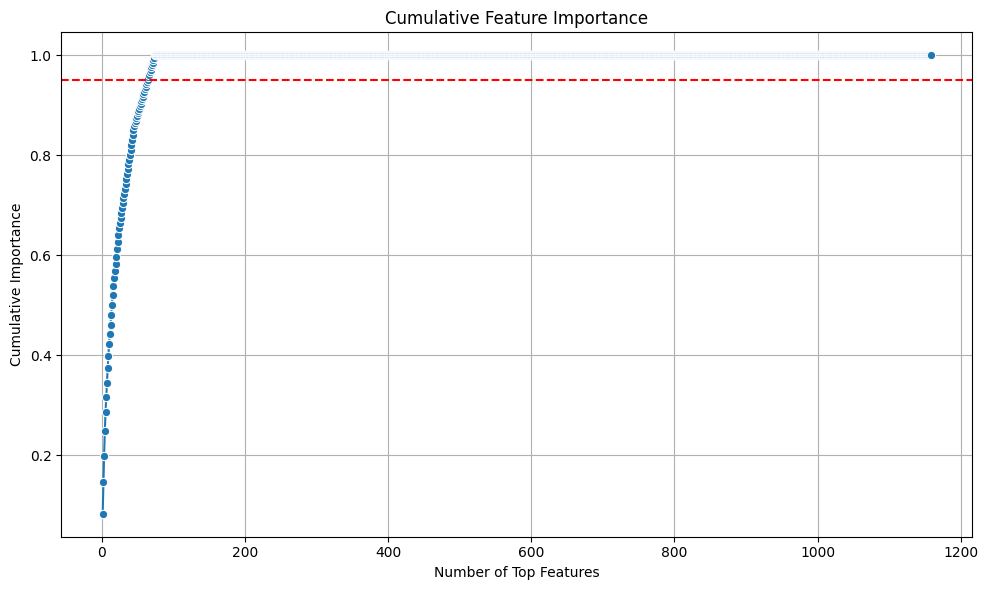

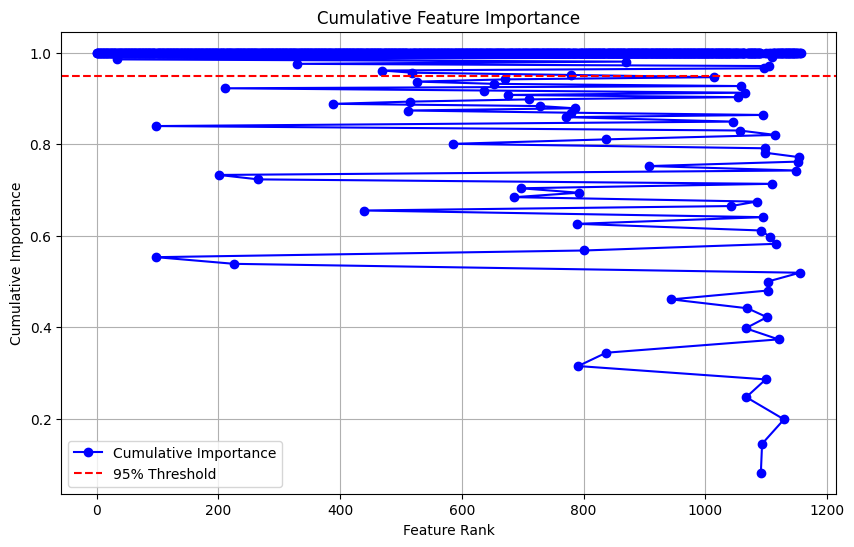

In [11]:
print(feature_importance)
pred = model.predict(X_test)[0]

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))  # Top 20 features
plt.title("LightGBM Feature Importance")
plt.tight_layout()
plt.show()

# Sort and normalize importance
feature_importance['Importance_Normalized'] = (
    feature_importance['Importance'] / feature_importance['Importance'].sum()
)

# Cumulative importance
feature_importance['cumulative_importance'] = (
    feature_importance['Importance_Normalized'].cumsum()
)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=range(1, len(feature_importance) + 1),
    y=feature_importance['cumulative_importance'],
    marker="o"
)
plt.axhline(y=0.95, color='r', linestyle='--')  # Optional: mark 95% importance
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Top Features')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot cumulative importance
plt.figure(figsize=(10, 6))
plt.plot(feature_importance['cumulative_importance'], marker='o', color='b', label='Cumulative Importance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.title('Cumulative Feature Importance')
plt.xlabel('Feature Rank')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
feature_importance[feature_importance['cumulative_importance'] < 0.95]

,Feature,Importance,Importance_Normalized,cumulative_importance
1091,onus_attribute_26,17,0.082524,0.082524
1093,onus_attribute_29,13,0.063107,0.145631
1129,bureau_enquiry_25,11,0.053398,0.199029
1067,onus_attribute_2,10,0.048544,0.247573
1099,onus_attribute_35,8,0.038835,0.286408
...,...,...,...,...
1059,bureau_444,1,0.004854,0.927184
652,transaction_attribute_658,1,0.004854,0.932039
526,transaction_attribute_530,1,0.004854,0.936893
671,bureau_14,1,0.004854,0.941748


In [13]:
columns = feature_importance[feature_importance['cumulative_importance'] < 0.95]['Feature'].to_list()

## Training Model

In [14]:
X_train = X_train[columns]
X_test = X_test[columns]

In [15]:
lgbm_model = lgb.LGBMClassifier(random_state=42, class_weight={0: 1, 1: 10}, device='gpu')

# Define the parameter grid for LightGBM
param_grid = {
    'n_estimators': [25, 30, 40],  # Number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate for boosting
    'max_depth': [2, 3],  # Maximum tree depth (-1 for no limit)
    'subsample': [0.8, 1.0],  # Fraction of data used for training
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
}

In [16]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='roc_auc',  # ROC AUC is suitable for imbalanced datasets
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Verbose output for progress tracking
    refit=True  # Refit the model on the best parameters
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC AUC Score: {grid_search.best_score_}")

# Retrieve the best model
best_lgbm_model = grid_search.best_estimator_

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Info] Number of positive: 2085, number of negative: 76347
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13630
[LightGBM] [Info] Number of data points in the train set: 78432, number of used features: 63
[LightGBM] [Info] Using GPU Device: Intel(R) Iris(R) Xe Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 17 dense feature groups (1.50 MB) transferred to GPU in 0.001596 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214513 -> initscore=-1.297935
[LightGBM] [Info] Start training from score -1.297935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

## Confidence Report

In [17]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Assume you have a trained model `clf` and test data X_test, y_test
y_proba = best_lgbm_model.predict_proba(X_test)[:, 1]   # probability of positive class
y_pred  = best_lgbm_model.predict(X_test)

# 1. Detailed per-sample confidence report
confidence_report = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Confidence": y_proba
})

# Optional: add "Correct/Incorrect" flag
confidence_report["Correct"] = (confidence_report["Actual"] == confidence_report["Predicted"]).astype(int)

# 2. Aggregate summary metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))



Classification Report:
              precision    recall  f1-score   support

           0      0.987     0.991     0.989     19087
           1      0.592     0.505     0.545       521

    accuracy                          0.978     19608
   macro avg      0.789     0.748     0.767     19608
weighted avg      0.976     0.978     0.977     19608

Confusion Matrix:
[[18906   181]
 [  258   263]]
ROC AUC: 0.8998764320602088


## ROC Curve

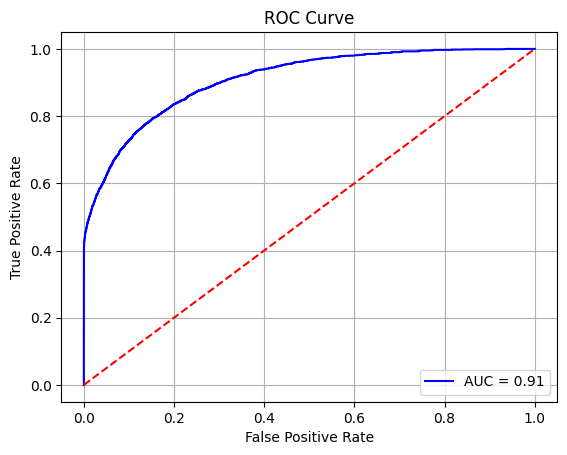

In [18]:
y_pred_train = best_lgbm_model.predict(X_train)
pred_prob_train = best_lgbm_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, pred_prob_train)
auc = roc_auc_score(y_train, pred_prob_train)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

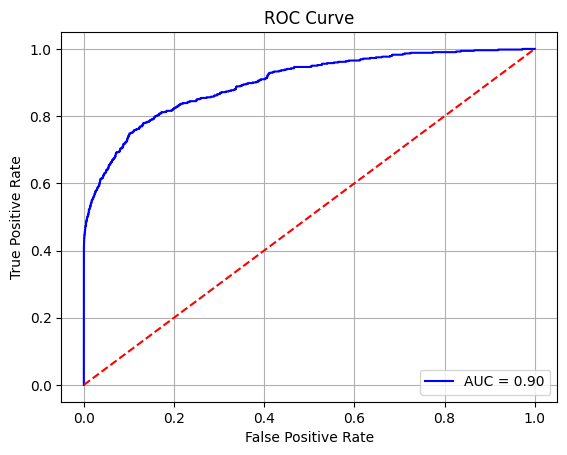

In [ ]:
y_pred = best_lgbm_model.predict(X_test)
pred_prob = best_lgbm_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
auc = roc_auc_score(y_test, pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Decile Chart

   decile  total  positives  negatives  cum_positives  cum_gain_%
0       1   1960          2       1958              2    0.383877
1       2   1961          3       1958              5    0.959693
2       3   1961          4       1957              9    1.727447
3       4   1961          9       1952             18    3.454894
4       5   1961         10       1951             28    5.374280
5       6   1960         23       1937             51    9.788868
6       7   1961         23       1938             74   14.203455
7       8   1961         23       1938             97   18.618042
8       9   1961         57       1904            154   29.558541
9      10   1961        367       1594            521  100.000000


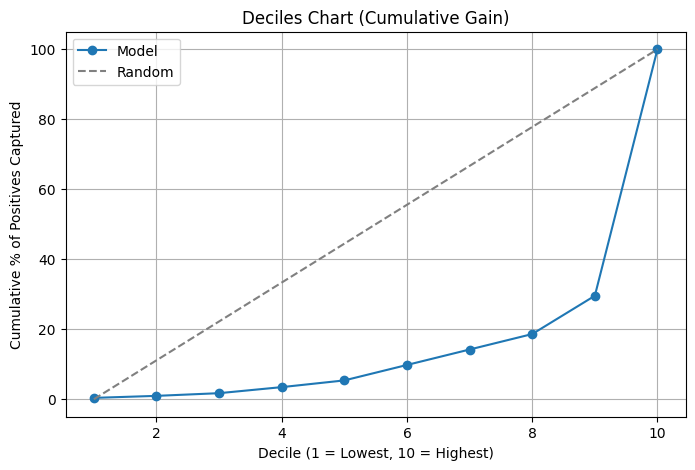

In [20]:
# Build dataframe
df = pd.DataFrame({
    'actual': np.asarray(y_test, dtype=int),
    'pred_prob': pred_prob
})

# Create deciles (tie-safe)
n_bins = min(10, len(df))  # in case dataset < 10 rows
r = df['pred_prob'].rank(method='first', pct=True)
df['decile'] = np.ceil(r * n_bins).astype(int).clip(1, n_bins)

# Sort by predicted probability (descending)
df = df.sort_values('pred_prob', ascending=False)

# Summarize by decile
decile_summary = df.groupby('decile', as_index=False).agg(
    total=('actual', 'count'),
    positives=('actual', 'sum'),
    negatives=('actual', lambda x: (x == 0).sum())
)
decile_summary['cum_positives'] = decile_summary['positives'].cumsum()
decile_summary['cum_gain_%'] = 100 * decile_summary['cum_positives'] / decile_summary['positives'].sum()

print(decile_summary)

# Plot cumulative gain curve
plt.figure(figsize=(8,5))
plt.plot(decile_summary['decile'], decile_summary['cum_gain_%'], marker='o', label='Model')
plt.plot(decile_summary['decile'], np.linspace(0, 100, n_bins), linestyle='--', color='gray', label='Random')
plt.title('Deciles Chart (Cumulative Gain)')
plt.xlabel(f'Decile (1 = Lowest, {n_bins} = Highest)')
plt.ylabel('Cumulative % of Positives Captured')
plt.grid(True)
plt.legend()
plt.show()

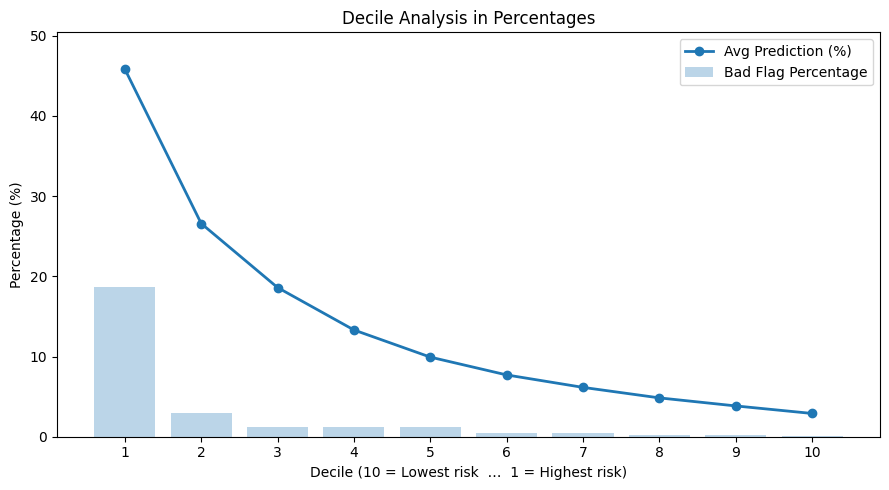

   decile  total  positives  negatives  avg_pred_pct  bad_flag_pct
9      10   1960          2       1958      2.900841      0.102041
8       9   1961          3       1958      3.840919      0.152983
7       8   1961          4       1957      4.842712      0.203978
6       7   1961          9       1952      6.152942      0.458950
5       6   1961         10       1951      7.705453      0.509944
4       5   1960         23       1937      9.927213      1.173469
3       4   1961         23       1938     13.312064      1.172871
2       3   1961         23       1938     18.599945      1.172871
1       2   1961         57       1904     26.585767      2.906680
0       1   1961        367       1594     45.839253     18.714941


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def decile_percent_plot(y_true, y_proba, n_deciles=10, title="Decile Analysis in Percentages"):
    df = pd.DataFrame({"actual": np.asarray(y_true, dtype=int),
                       "pred_prob": np.asarray(y_proba, dtype=float)})

    # Rank (tie-safe), make deciles by probability (1 = highest risk, n_deciles = lowest)
    r = df["pred_prob"].rank(method="first", pct=True)
    df["decile"] = (n_deciles - np.ceil(r * n_deciles).astype(int) + 1).clip(1, n_deciles)

    # Aggregate by decile
    dec = (df.groupby("decile", as_index=False)
             .agg(total=("actual", "count"),
                  positives=("actual", "sum")))
    dec["negatives"] = dec["total"] - dec["positives"]

    # Metrics for the plot
    dec["avg_pred_pct"] = 100 * df.groupby("decile")["pred_prob"].mean().values
    dec["bad_flag_pct"] = 100 * dec["positives"] / dec["total"]

    # Sort x as 10..1 (to match your screenshot)
    dec = dec.sort_values("decile", ascending=False)

    # ---- Plot ----
    plt.figure(figsize=(9,5))
    # Bars: bad-flag percentage
    plt.bar(dec["decile"], dec["bad_flag_pct"], alpha=0.3, label="Bad Flag Percentage")
    # Line: average prediction percentage
    plt.plot(dec["decile"], dec["avg_pred_pct"], marker="o", linewidth=2, label="Avg Prediction (%)")

    # Cosmetics
    plt.title(title)
    plt.xlabel("Decile (10 = Lowest risk  …  1 = Highest risk)")
    plt.ylabel("Percentage (%)")
    plt.xticks(dec["decile"])                      # show 10..1
    plt.ylim(0, max(dec["bad_flag_pct"].max(), dec["avg_pred_pct"].max()) * 1.1)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dec[["decile","total","positives","negatives","avg_pred_pct","bad_flag_pct"]]

# Usage:
# pred_prob = clf.predict_proba(X_test)[:,1]
summary = decile_percent_plot(y_test, pred_prob)
print(summary)


In [22]:
joblib.dump(best_lgbm_model, 'best_lgbm_model.pkl')

['best_lgbm_model.pkl']